In [7]:
!pip install -U -q sentence-transformers
!pip install -U -q faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 11.0 MB/s eta 0:00:00


In [8]:
import pandas as pd
import time
from tqdm import tqdm
import seaborn as sns
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')

In [9]:
data = pd.read_csv('/content/wiki_movie_plots_deduped.csv',memory_map=True)
data.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [10]:
data=data[data.columns.drop(["Release Year","Origin/Ethnicity","Director","Cast","Wiki Page"])]

In [11]:
data

,Title,Genre,Plot
0,Kansas Saloon Smashers,unknown,"A bartender is working at a saloon, serving dr..."
1,Love by the Light of the Moon,unknown,"The moon, painted with a smiling face hangs ov..."
2,The Martyred Presidents,unknown,"The film, just over a minute long, is composed..."
3,"Terrible Teddy, the Grizzly King",unknown,Lasting just 61 seconds and consisting of two ...
4,Jack and the Beanstalk,unknown,The earliest known adaptation of the classic f...
...,...,...,...
34881,The Water Diviner,unknown,"The film begins in 1919, just after World War ..."
34882,Çalgı Çengi İkimiz,comedy,"Two musicians, Salih and Gürkan, described the..."
34883,Olanlar Oldu,comedy,"Zafer, a sailor living with his mother Döndü i..."
34884,Non-Transferable,romantic comedy,The film centres around a young woman named Am...


In [12]:
import gc
df = data[['Title','Plot']]
del data
gc.collect()

53

In [13]:
df.dropna(inplace=True)
df.drop_duplicates(subset=['Plot'],inplace=True)

<ipython-input-13-42cc88017bc9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
<ipython-input-13-42cc88017bc9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset=['Plot'],inplace=True)


<ipython-input-14-be08a03964eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['doc_len'] = df['Plot'].apply(lambda words: len(words.split()))
<ipython-input-14-be08a03964eb>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['doc_len'], hist=True, kde=True, color='b', label='doc len')


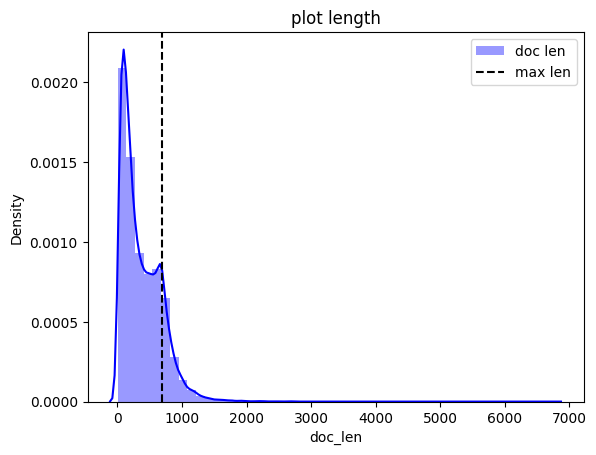

In [14]:
df['doc_len'] = df['Plot'].apply(lambda words: len(words.split()))
max_seq_len = np.round(df['doc_len'].mean() + df['doc_len'].std()).astype(int)
sns.distplot(df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('plot length'); plt.legend()
plt.show()

In [15]:
import faiss
encoded_data = model.encode(df.Plot.tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(df))))
faiss.write_index(index, 'movie_plot.index')

In [16]:
encoded_data.shape

(33869, 768)

In [17]:
df.iloc[5]["Plot"]

'Alice follows a large white rabbit down a "Rabbit-hole". She finds a tiny door. When she finds a bottle labeled "Drink me", she does, and shrinks, but not enough to pass through the door. She then eats something labeled "Eat me" and grows larger. She finds a fan when enables her to shrink enough to get into the "Garden" and try to get a "Dog" to play with her. She enters the "White Rabbit\'s tiny House," but suddenly resumes her normal size. In order to get out, she has to use the "magic fan."\r\nShe enters a kitchen, in which there is a cook and a woman holding a baby. She persuades the woman to give her the child and takes the infant outside after the cook starts throwing things around. The baby then turns into a pig and squirms out of her grip. "The Duchess\'s Cheshire Cat" appears and disappears a couple of times to Alice and directs her to the Mad Hatter\'s "Mad Tea-Party." After a while, she leaves.\r\nThe Queen invites Alice to join the "ROYAL PROCESSION": a parade of marching 

In [18]:
def fetch_movie_info(dataframe_idx):
    info=df.iloc[dataframe_idx]
    meta_dic={}
    meta_dic["Title"]=info["Title"]
    return meta_dic

In [19]:
def search(query,top_k,index,model):
    t=time.time()

    query_vector=model.encode([query])
    top_k=index.search(query_vector,top_k)

    print('>>>> Results in Total Time: {}'.format(time.time()-t))

    top_k_ids=top_k[1].tolist()[0]
    top_k_ids=list(np.unique(top_k_ids))
    results=[fetch_movie_info(idx) for idx in top_k_ids]
    return results

In [20]:
from pprint import pprint

query="Artificial Intelligence based action movie"
results=search(query, top_k=5, index=index, model=model)

print("\n")
for result in results:
    print('\t',result)

>>>> Results in Total Time: 0.07303667068481445


	 {'Title': 'The Cape Canaveral Monsters'}
	 {'Title': 'Small Soldiers'}
	 {'Title': 'Chappie'}
	 {'Title': 'Armed Response'}
	 {'Title': 'Galactic Armored Fleet Majestic Prince: Genetic Awakening'}
